In [1]:
#!/usr/bin/env python3
## import libraries
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lab606a/.virtualenvs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lab606a/.virtualenvs

In [2]:
# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
dataset = pd.read_csv("./exp20200601/fixed top/visurement12.csv", header=None)
dataset = dataset.fillna(0)
dataset

,0,1,2
0,73.173134,312.323425,43.833324
1,73.142029,301.987854,45.068867
2,73.360321,289.345276,46.395935
3,73.320084,278.674896,47.213661
4,73.520638,267.309875,47.682510
5,73.466103,255.255280,48.083275
6,73.650566,245.045151,47.804920
7,73.372620,236.314026,47.146770
8,73.537209,224.891815,46.128853
9,73.480583,214.951889,45.217678


In [4]:
dataset = np.array(dataset)
dataset.shape

(39, 3)

In [5]:
dataset = dataset.reshape(1,dataset.shape[0]*dataset.shape[1])
dataset.shape

(1, 117)

In [6]:
np.set_printoptions(suppress=True)

In [41]:
#!/usr/bin/env python3
import rospy
from std_msgs.msg import Float32MultiArray
import numpy as np
import pandas as pd
import cupy as cp
from keras.models import load_model
from keras.preprocessing import sequence
import tensorflow as tf
import matplotlib.pyplot as plt
import sys

graph = tf.get_default_graph()

# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

np.set_printoptions(suppress=True)

class Listener:
    def __init__(self):
        self.__time_step = 9
        self.__tmp = cp.zeros([1,3])
        self.__arr_classification = cp.zeros([1,90])
        self.__vis_point = cp.zeros((1,3))
        self.__vis_balls = cp.zeros((self.__time_step,3))
        self.__vis_balls2 = cp.zeros((1,4))
        self.__predction_balls = cp.zeros((1,self.__time_step,3))
        self.__arr_prediction = cp.zeros([1,self.__time_step*3])
        self.__arr_pred_possible = cp.zeros((1,4))
        self.__diff = cp.zeros([1,3])
        self.__padding_done = False
        self.__cnt = 1
        self.__num = 1
        self.__max_index = 0
        self.traj_done = False
        self.__coor = -10*cp.ones(6)
        self.__find_possible_point = False
        self.__cal_possible_point = False
        self.__vis_possible_point = False
        self.__vis_hitting_point = cp.zeros((1,4))
        self.__hitting_point = -45
        self.__hitting_timimg = 0
        self.__possible_point = cp.zeros((1,4))
        self.__pred = cp.zeros([1,self.__time_step,3])
        self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
        self.__time = 0.016667
        self.__delta_T = 0.016667
        self.__anchor = 0
        self.__rowww = 0
        self.__direction = 'top5'
        self.fig, self.ax = plt.subplots(2,2, figsize=(10.24,7.2))
        self.__csv_path = '/home/lab606a/catkin_ws/src/pointcloud/offline/'
        self.__model = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_top6')
        self.__classifier = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/classification_30ball_20200505_256to8')
        rospy.loginfo("loaded classification model")
        self.__pred_top5 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_top5')
        self.__pred_top6 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_top6')
        rospy.loginfo("loaded top prediction model")
        self.__pred_left5 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_left5')
        self.__pred_left6 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_left6')
        rospy.loginfo("loaded left prediction model")
        self.__pred_right5 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_right5')
        self.__pred_right6 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_right6')
        rospy.loginfo("loaded right prediction model")
        self.__pred_back5 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_back5')
        self.__pred_back6 = load_model('/home/lab606a/catkin_ws/src/pointcloud/models/60hz_culstm/prediction_back6')
        rospy.loginfo("loaded back prediction model")
        rospy.loginfo("Load fixed model")

    ## print spin direction and speed
    def top5(self):
        print("top spin speed 5")
        self.__model = self.__pred_top5
        self.__direction = '_top5'

    def top6(self):
        print("top spin speed 6")
        self.__model = self.__pred_top6
        self.__direction = '_top6'

    def left5(self):
        print("left spin speed 5")
        self.__model = self.__pred_left5
        self.__direction = '_left5'

    def left6(self):
        print("left spin speed 6")
        self.__model = self.__pred_left6
        self.__direction = '_left6'

    def right5(self):
        print("right spin speed 5")
        self.__model = self.__pred_right5
        self.__direction = '_right5'

    def right6(self):
        print("right spin speed 6")
        self.__model = self.__pred_right6
        self.__direction = '_right6'

    def back5(self):
        print("back spin speed 5")
        self.__model = self.__pred_back5
        self.__direction = '_back5'

    def back6(self):
        print("back spin speed 6")
        self.__model = self.__pred_back6
        self.__direction = '_back6'

    def append_pred(self): ## Exhaustive
        with graph.as_default():
            self.__pred = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1))
        while not self.__find_possible_point == True:
            self.__pred = cp.array(self.__pred)
            if ( -50 < float(cp.min(self.__pred[self.__pred.shape[0]-1,:,:])) < -40): ## find possible hitting point
                index = cp.argmin(self.__pred[self.__pred.shape[0]-1,:,:])
                row = int((index-1)/3)
                count_down = row + (self.__pred.shape[0]-1)*9
                self.__find_possible_point = True
                self.__anchor = self.__pred.shape[0]-1
                print("count down = ", int(count_down))
                #index = cp.argmin(self.__anchor[self.__anchor,:,:])
                #row = int((index-1)/3)
                self.__pred[self.__anchor, row+1:, :] = 0
                self.__pred_for_offline = self.__pred

            else: ## predict next time step
                self.__pred = cp.vstack((self.__pred, cp.zeros([1,self.__time_step,3])))
                with graph.as_default():
                    self.__pred[self.__pred.shape[0]-1,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[self.__pred.shape[0]-2,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
                if (self.__pred.shape[0] >= 8):
                    self.__pred = cp.zeros([1,self.__time_step,3])
                    self.__find_possible_point = True
                
    def update_prediction(self):
        with graph.as_default():
            self.__pred[0,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
            for i in range(1, self.__pred.shape[0]):
                self.__pred[i,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[i-1,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
            '''
            index = cp.argmin(self.__pred[self.__anchor,:,:])
            row = int((index-1)/3)
            if (row < 8):
                self.__pred[self.__anchor, row+1:, :] = 0
            if (self.__anchor != self.__pred.shape[0]-1):
                self.__pred[self.__anchor+1:, :, :] = 0
            if (self.__anchor == 0) and ( -10 < float(cp.min(self.__pred[self.__anchor,0,:])) < 10):
                self.__pred[self.__anchor,0,:] = 0
            '''
            #self.__pred_for_offline = cp.vstack((self.__pred_for_offline, self.__pred))
            

    def modify(self):
        #index = cp.argmin(self.__pred[self.__anchor,:,:])
        #row = int((index-1)/3)
        if (self.__rowww < 8):
            self.__pred[self.__anchor, self.__rowww+1:, :] = 0
        if (self.__anchor != self.__pred.shape[0]-1):
            self.__pred[self.__anchor+1:, :, :] = 0
        if (self.__anchor == 0) and (self.__rowww == 0) and ( -10 < float(cp.min(self.__pred[self.__anchor,0,:])) < 10):
            self.__pred[self.__anchor,0,:] = 0
        self.__pred_for_offline = cp.vstack((self.__pred_for_offline, self.__pred))

    def calculate_hitting_point(self, arr):
        #print("cnt = ", self.__cnt)
        arr = cp.array(arr)
        self.__cal_possible_point = False
        while not self.__cal_possible_point == True:
            print(arr[self.__anchor,:,:])
            if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= -35) and (self.__anchor >= 0):
                #print("anchor = ", self.__anchor)
                index = cp.argmin(arr[self.__anchor,:,:])
                row = int((index-1)/3)
                self.__rowww = row
                if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= -45): ## interpolation
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case a1")
                        self.__vis_point = cp.array(self.__vis_point)
                        w1 = (self.__hitting_point-self.__vis_point[:,1]) / (arr[self.__anchor,row,1]-self.__vis_point[:,1])
                        self.__possible_point = w1*arr[self.__anchor,row,:] + (1-w1)*self.__vis_point.reshape(1,1,3)
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))

                        #w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor-1,self.__time_step-1,1])
                        #self.__possible_point = w1*arr[self.__anchor-1,self.__time_step-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        #self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        #self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case a2")
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor,row-1,1])
                        self.__possible_point = w1*arr[self.__anchor,row-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                elif (-45 < float(cp.min(arr[self.__anchor,:,:])) <= -40):
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case b1")
                        if (self.__diff[:,1] > 0):
                            w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                            if w1 < 1:
                                self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                                self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                                self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                                print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case b2")
                        self.__diff = arr[self.__anchor,row-1,:]-arr[self.__anchor,row,:]
                        self.__diff = self.__diff.reshape(1,3)
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                        if w1 < 1:
                            self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                            self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                            self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                            print("hitting timing and position = ", self.__possible_point)
                else:
                    self.__possible_point = self.__possible_point

                self.__cal_possible_point = True
                #self.pub_prediction()
                '''
                if (row < 8):
                    arr[self.__anchor, row+1:, :] = 0
                if (self.__anchor != self.__pred.shape[0]-1):
                    arr[self.__anchor+1:, :, :] = 0
                if (self.__anchor == 0) and ( -10 < float(cp.min(arr[self.__anchor,0,:])) < 10):
                    arr[self.__anchor,0,:] = 0
                '''
                #self.__pred_for_offline = cp.vstack((self.__pred_for_offline, arr))
                #self.__cnt += 1
                if (self.__arr_pred_possible.shape[0] == 1) and (int(self.__arr_pred_possible[0,2]) == 0):
                    self.__arr_pred_possible = self.__possible_point.reshape(1,4)
                else:
                    self.__arr_pred_possible = cp.vstack((self.__arr_pred_possible, self.__possible_point.reshape(1,4)))
            else:
                if ((self.__anchor-1) >= 0) and (abs(float(cp.min(arr[self.__anchor,:,:]))-self.__hitting_point) >= 22.5):
                    self.__anchor = self.__anchor -1
                    #print("case c1")
                else:
                    self.__cal_possible_point = True

    def calculate_vis_hitting_point(self):
        if (-50 <= float(cp.min(self.__vis_balls2)) <= -45):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row,2]-self.__vis_balls2[row-1,2])
            self.__vis_hitting_point = (1-w1)*self.__vis_balls2[row,:] + w1*self.__vis_balls2[row-1,:]
        elif (-45 < float(cp.min(self.__vis_balls2)) < -40):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row-1,2]-self.__vis_balls2[row,2])
            self.__vis_hitting_point = self.__vis_balls2[row,:] - w1*(self.__vis_balls2[row-1,:]-self.__vis_balls2[row,:])
        print("vis hitting point = ", self.__vis_hitting_point)


    def show_spin_direction(self, max_index):
        ## make dictionary to replace switch case
        dictionary = {0:self.top5, 1:self.top6, 2:self.left5, 3:self.left6, 4:self.right5, 5:self.right6, 6:self.back5, 7:self.back6}
        funcToCall = dictionary[max_index]
        funcToCall()

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def classification(self):
        ## call classifier
        with graph.as_default():
            classes = self.__classifier.predict(cp.asnumpy(self.__arr_classification.reshape(1,30,3)), verbose=1)
        ## figure out which direction is
        self.__max_index = np.argmax(classes)
        #print("number of input balls = ", self.__cnt)
        ## show result
        if (self.__cnt >= 9):
            self.show_spin_direction(self.__max_index)
        #self.__cnt += 1

    def padding(self):
        # if __tmp is empty, init array
        if (self.__padding_done == False):
            self.__tmp = self.__vis_point ## pad first point
            self.__padding_done = True
            self.__vis_balls = self.__vis_point.reshape(1,3)
        else:
        # if __tmp is not empty, then filled array
            self.__tmp = cp.hstack((self.__tmp, self.__vis_point))
            self.__vis_balls = cp.vstack((self.__vis_balls, self.__vis_point))
            if (self.__tmp.shape[1] == 15): ## when colect 5 balls
                self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## asigne to classification input array
            if (self.__tmp.shape[1] == 27):
                #self.__vis_balls = self.__tmp.reshape(1,self.__time_step,3)
                self.__arr_prediction[:,:] = self.__tmp ## for predct next 5 steps
            if (self.__tmp.shape[1] > 27): ## when colect over 5 balls
                #self.__vis_balls = cp.vstack((self.__vis_balls, self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):].reshape(1,self.__time_step,3))) ## visual measurement point for calculate error
                self.__arr_prediction[:,:] = self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):] ## rolling visual measurement for predct next 5 steps
                if (self.__tmp.shape[1] <= 90): ## when colect under 31 balls
                    self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## still asigne to classification input array

    def save_data(self):
        visurement_balls = cp.asnumpy(self.__vis_balls)
        pred_trajs = cp.asnumpy(self.__pred_for_offline.reshape(self.__pred_for_offline.shape[0]*self.__pred_for_offline.shape[1], self.__pred_for_offline.shape[2]))

        df_vis = pd.DataFrame(data=visurement_balls)
        df_pred = pd.DataFrame(data=pred_trajs)

        vis_name = self.__csv_path + 'visurement' + str(self.__num) + '.csv'
        pred_name = self.__csv_path + 'prediction' + str(self.__num) + '.csv'

        df_vis.to_csv(vis_name, header=0, index=0)
        df_pred.to_csv(pred_name, header=0, index=0)

    def final_padding(self):
        for i in range((self.__time_step-1)): ## padding zeros 4 times
            print("Time = ", self.__time)
            print("visual measurement = ", self.__vis_point)
            self.__tmp = cp.asnumpy(self.__tmp)
            self.__tmp = sequence.pad_sequences(self.__tmp, maxlen=(self.__tmp.shape[1]+3), padding='post', dtype='float32')
            self.__tmp = cp.array(self.__tmp)

            self.__vis_balls = cp.vstack((self.__vis_balls, self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):].reshape(1,self.__time_step,3)))
            self.__arr_prediction[:,:] = self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):] ## rolling visual measurement for predct next 5 steps
            self.show_spin_direction(self.__max_index) ## predct next 5 steps
            self.__time += self.__delta_T
            
    def predict_traj(self):
        #self.__model = self.__prediction_model

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()
            
    def modify_offline_plot(self, tmp):
        arr = np.array([0,0,0,0])
        for i in range (tmp.shape[0]):
            if i % 2 != 0:
                arr = np.vstack((arr, tmp[i,:]))
        return arr[1:,:]

    def plot_res(self):
        self.__arr_pred_possible = cp.round_(self.__arr_pred_possible, 4)
        self.__vis_hitting_point = cp.round_(self.__vis_hitting_point, 4)
        
        self.__arr_pred_possible = self.modify_offline_plot(self.__arr_pred_possible)
        #self.__vis_hitting_point = self.modify_offline_plot(self.__vis_hitting_point)

        update_times = cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0])
        t = self.__arr_pred_possible[:,0]
        x = self.__arr_pred_possible[:,1]
        z = self.__arr_pred_possible[:,3]
        Euclidean_vis = cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2)))
        Euclidean_pred = cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))

        plt.figure(figsize=(8,7))
        

        ## plot hitting timing
        plt.clf()
        #plt.subplot(4,2,1)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg (sec)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_timing' + '.png'
        plt.savefig(name)

        plt.clf()
        #plt.subplot(4,2,2)
        err = cp.abs((t-self.__vis_hitting_point[0])*1000)
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg error (ms)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_timing_error' + '.png'
        plt.savefig(name)

        ## plot Euclidean distance
        plt.clf()
        #plt.subplot(4,2,3)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_distance' + '.png'
        plt.savefig(name)

        plt.clf()
        #plt.subplot(4,2,4)
        err = cp.abs((Euclidean_pred-Euclidean_vis))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_distance_error' + '.png'
        plt.savefig(name)

        ## plot x coordinate
        plt.clf()
        #plt.subplot(4,2,5)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_X-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        #plt.subplot(4,2,6)
        err = cp.abs((x-self.__vis_hitting_point[1]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_X-coordinate_error' + '.png'
        plt.savefig(name)

        ## plot z coordinate
        plt.clf()
        #plt.subplot(4,2,7)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_Z-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        #plt.subplot(4,2,8)
        err = cp.abs((z-self.__vis_hitting_point[3]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = './exp20200601/' + str(self.__num) + '_Z-coordinate_error' + '.png'
        plt.savefig(name)
        
        #plt.show()
    
    def plot_error(self):
        self.ax[0,0].remove()
        self.ax[0,1].remove()
        self.ax[1,0].remove()
        self.ax[1,1].remove()
        #self.fig.clf()
        self.__arr_pred_possible = cp.round_(self.__arr_pred_possible, 4)
        self.__vis_hitting_point = cp.round_(self.__vis_hitting_point, 4)
        #self.__vis_hitting_point = self.__vis_hitting_point.reshape(1,self.__vis_hitting_point.shape[0])

        update_times = cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0])
        t = self.__arr_pred_possible[:,0]
        x = self.__arr_pred_possible[:,1]
        z = self.__arr_pred_possible[:,3]
        Euclidean_vis = cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2)))
        Euclidean_pred = cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))
        
        #fig, ax = plt.subplots(2,2, figsize=(10.24,7.2))
        
        self.fig, self.ax = plt.subplots(2,2, figsize=(12.0,10.0)) ##(10.24,7.2)

        self.ax[0,0].plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green')
        self.ax[0,0].plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        self.ax[0,0].scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        self.ax[0,0].grid(True)
        self.ax[0,0].set_xlabel('update times')
        self.ax[0,0].set_ylabel('hitting timimg (sec)')
        self.ax[0,0].set_title('Hitting timimg')

        self.ax[0,1].plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green')
        self.ax[0,1].plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        self.ax[0,1].scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        self.ax[0,1].grid(True)
        self.ax[0,1].set_xlabel('update times')
        self.ax[0,1].set_ylabel('Euclidean distance (cm)')
        self.ax[0,1].set_title('Euclidean distance')

        self.ax[1,0].plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green')
        self.ax[1,0].plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        self.ax[1,0].scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        self.ax[1,0].grid(True)
        self.ax[1,0].set_xlabel('update times')
        self.ax[1,0].set_ylabel('X-coordinate (cm)')
        self.ax[1,0].set_title('X-coordinate')

        self.ax[1,1].plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green')
        self.ax[1,1].plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        self.ax[1,1].scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        self.ax[1,1].grid(True)
        self.ax[1,1].set_xlabel('update times')
        self.ax[1,1].set_ylabel('Z-Coordinate (cm)')
        self.ax[1,1].set_title('Z-Coordinate')

        '''
        #plt.clf()
        plt.figure(figsize=(10.24,7.2))
        plt.subplot(2,2,1)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green')
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.grid(True)
        plt.xlabel('update times')
        plt.ylabel('hitting timimg')
        
        plt.subplot(2,2,2)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green')
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.grid(True)
        plt.xlabel('update times')
        plt.ylabel('Euclidean distance')
        
        plt.subplot(2,2,3)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green')
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.grid(True)
        plt.xlabel('update times')
        plt.ylabel('Coordinate X')

        plt.subplot(2,2,4)
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green')
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.grid(True)
        plt.xlabel('update times')
        plt.ylabel('Coordinate Z')

        #plt.pause(0.00000000001)
        plt.show()
        '''
        #name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + self.__direction + str(rospy.get_time()) + '.png'
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + self.__direction + '.png'
        
        #self.fig.savefig(name)

        #self.fig.pause(0.001)
        #plt.savefig(name)
        #plt.clf()
        
        #self.fig.clf()
        #self.ax[0,0].remove()
        #self.ax[0,1].remove()
        #self.ax[1,0].remove()
        #self.ax[1,1].remove()


        #self.fig.clf()
        self.fig.show()
        
    def return_vis_point(self):
        return self.__vis_hitting_point
    
    def return_pred_res(self):
        return self.__arr_pred_possible
    
    def reset_arr_pred(self):
        self.__arr_pred_possible = cp.zeros((1,4))
        
    def reset_args(self):
        self.__padding_done = False
        self.__arr_classification = cp.zeros([1,90])
        self.__coor = -10*cp.ones(6)
        self.__vis_balls = cp.zeros((self.__time_step,3))
        self.__cnt = 1
        self.__pred = cp.zeros([1,self.__time_step,3])
        self.__vis_balls2 = cp.zeros((1,4))
        self.__arr_pred_possible = cp.zeros((1,4))
        self.__find_possible_point = False
        self.__vis_possible_point = False
        self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
        self.__time = 0.016667 ## reset time
        self.traj_done = False
    
    def print_arr_pred(self):
        print(self.__arr_pred_possible)
        return self.__arr_pred_possible
        
    def return_plot_arg(self):
        return self.__arr_pred_possible, self.__vis_hitting_point, cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0]), self.__arr_pred_possible[:,0], self.__arr_pred_possible[:,1], self.__arr_pred_possible[:,3], cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2))), cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))

    def assigne(self, visss):
        #a = data.data
        self.__vis_point = cp.array(visss).reshape(1,3)
        #print(self.__vis_point)

        if (-50 < self.__vis_point[:,1] < -30):
            tmp = cp.hstack((self.__time, self.__vis_point.reshape(3,)))
            if self.__vis_possible_point == False:
                self.__vis_balls2 = tmp.reshape(1,4)
                self.__vis_possible_point = True
            else:
                self.__vis_balls2 = cp.vstack((self.__vis_balls2, tmp.reshape(1,4)))


        if self.traj_done == False:
            print("\nTime = ", self.__time) ## show current time
            print("visual measurement = ", self.__vis_point) ## show visual measurement coordinate
            self.padding() ## colect 5 balls
            
            if ((self.__tmp.shape[1] >= 15) and (self.__tmp.shape[1] <= 90)): ## while colect balls over 5 balls and under 30 balls
                self.classification() ## doing classification and prediction
            if (self.__tmp.shape[1] > 90): ## while colect balls over 30 balls, stop doing classification
                self.show_spin_direction(self.__max_index) ## skip classification doing prediction
            
            if (self.__tmp.shape[1] >= 27):
                self.predict_traj()
            #self.for_ttbot()
            self.__time += self.__delta_T
            self.__cnt += 1
            
        else:
            #print("aaaaa")
            if (self.__padding_done == True):
                self.calculate_vis_hitting_point()
                print("pred hitting point = \n", self.__arr_pred_possible)
                #if (self.__pred_for_offline.shape[0] != 1):
                #self.plot_error()
                self.plot_res()
                    #self.save_data()
                self.__num += 1

            
            self.__padding_done = False
            self.__arr_classification = cp.zeros([1,90])
            self.__coor = -10*cp.ones(6)
            self.__vis_balls = cp.zeros((self.__time_step,3))
            self.__cnt = 1
            self.__pred = cp.zeros([1,self.__time_step,3])
            self.__vis_balls2 = cp.zeros((1,4))
            #self.__arr_pred_possible = cp.zeros((1,4))
            self.__find_possible_point = False
            self.__vis_possible_point = False
            self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
            self.__time = 0.016667 ## reset time
            self.traj_done = False
            

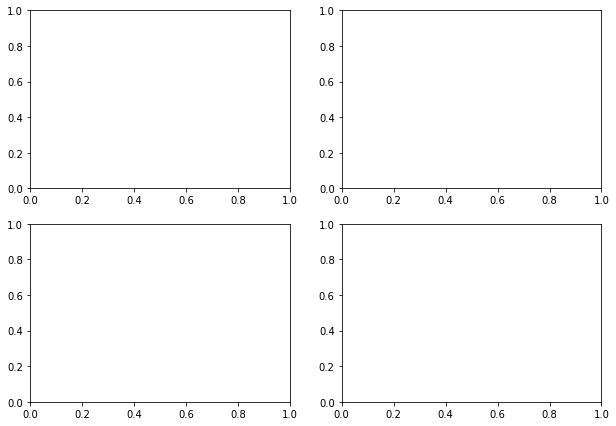

In [42]:
obj = Listener()


Time =  0.016667
visual measurement =  [[ 73.17313385 312.32342529  43.83332443]]

Time =  0.033334
visual measurement =  [[ 73.14202881 301.987854    45.06886673]]

Time =  0.050001000000000004
visual measurement =  [[ 73.36032104 289.34527588  46.39593506]]

Time =  0.066668
visual measurement =  [[ 73.32008362 278.67489624  47.21366119]]

Time =  0.083335
visual measurement =  [[ 73.52063751 267.30987549  47.68251038]]
1/1 [==============================] - 3s 3s/step

Time =  0.10000200000000001
visual measurement =  [[ 73.4661026  255.25527954  48.08327484]]
1/1 [==============================] - 0s 4ms/step

Time =  0.11666900000000001
visual measurement =  [[ 73.6505661  245.04515076  47.8049202 ]]
1/1 [==============================] - 0s 4ms/step

Time =  0.133336
visual measurement =  [[ 73.37261963 236.31402588  47.14677048]]
1/1 [==============================] - 0s 5ms/step

Time =  0.150003
visual measurement =  [[ 73.53720856 224.89181519  46.12885284]]
1/1 [===========

right spin speed 5
1/1 [==============================] - 0s 1ms/step
[[103.48253632 -31.55167007  28.9063797 ]
 [105.27317047 -37.28486252  28.10614395]
 [106.42775726 -43.64127731  26.25039673]
 [108.06616211 -49.55660629  25.06697845]
 [ -0.65573883  -0.00183487   0.00900364]
 [  0.05116653   0.57465172   0.29649639]
 [ -0.06886292   0.07986069   0.0571413 ]
 [  0.00670624   0.19150162   0.11633587]
 [ -0.40732574   0.19212723  -0.00187302]]
count down =  30
case a2
hitting timing and position =  [  0.74618667 106.804091   -45.          25.97857123]
1/1 [==============================] - 0s 1ms/step
[[103.48253632 -31.55167007  28.9063797 ]
 [105.27317047 -37.28486252  28.10614395]
 [106.42775726 -43.64127731  26.25039673]
 [108.06616211 -49.55660629  25.06697845]
 [ -0.65573883  -0.00183487   0.00900364]
 [  0.05116653   0.57465172   0.29649639]
 [ -0.06886292   0.07986069   0.0571413 ]
 [  0.00670624   0.19150162   0.11633587]
 [ -0.40732574   0.19212723  -0.00187302]]
count down 

1/1 [==============================] - 0s 1ms/step
[[ 90.65478516 -46.74964523  21.79602814]
 [ -0.40911102  -0.09739304  -0.12961483]
 [ -0.23681641  -0.00024986  -0.37067509]
 [ -0.38124084   0.12111282  -0.19430733]
 [  0.00622559  -0.05270004  -0.08850956]
 [ -0.01919556  -0.02547455  -0.03347683]
 [ -0.02359772  -0.03307343  -0.00457859]
 [  0.01016235  -0.02892685   0.03486443]
 [  0.02874756  -0.02807617   0.06192684]]
count down =  27
case a1
hitting timing and position =  [  0.78318317  90.4760331  -45.          21.76933834]

Time =  0.33333999999999986
visual measurement =  [[ 72.44159698 121.85810852  14.20925808]]
1/1 [==============================] - 0s 4ms/step
right spin speed 5
1/1 [==============================] - 0s 2ms/step
[[-0.01260376 -0.02622223 -0.010355  ]
 [-0.03036118 -0.02214622 -0.01790905]
 [ 0.05424118  0.01841736  0.00636578]
 [ 0.00304413 -0.02153015  0.00970364]
 [ 0.0038147  -0.03466415  0.01706123]
 [ 0.00155258 -0.03839493  0.01883125]
 [ 0.000579

1/1 [==============================] - 0s 2ms/step
[[ 84.73852539 -36.67585373  33.35253906]
 [ 85.68493652 -43.08744431  32.17355347]
 [ 85.81613159 -48.93024826  31.04756165]
 [ -0.51842499   0.32474899  -0.66264629]
 [  0.02043152   0.36328506  -0.13645744]
 [ -0.08457947   0.23694611  -0.23714733]
 [  0.11608124   0.10107422  -0.15810585]
 [  0.03494263   0.1027565   -0.24756527]
 [  0.05138397   0.03689575  -0.28296375]]
count down =  20
case a2
hitting timing and position =  [  0.7445593   85.72788129 -45.          31.80497665]

Time =  0.4166749999999998
visual measurement =  [[72.04342651 76.81728363 10.56484985]]
1/1 [==============================] - 0s 4ms/step
right spin speed 5
1/1 [==============================] - 0s 1ms/step
[[0.93785095 0.99285889 0.19464588]
 [0.97220612 0.78530884 0.21966648]
 [1.00536728 0.81414795 0.2455492 ]
 [0.95774841 0.78188324 0.24201488]
 [0.95851517 0.77204895 0.24848652]
 [0.95756531 0.76935196 0.24977398]
 [0.95697403 0.76902199 0.2504615

hitting timing and position =  [  0.65886368  74.23565456 -45.          25.04950164]

Time =  0.5000099999999997
visual measurement =  [[71.83338165 31.75702477 24.98719597]]
1/1 [==============================] - 0s 4ms/step
right spin speed 5
1/1 [==============================] - 0s 1ms/step
[[-16.52334595  -2.50976944  -3.74046993]
 [ -7.23825073  -2.28158188  -3.27268696]
 [ -7.59838486  -2.45569229  -2.88222218]
 [ -6.73390961  -2.92730331  -2.7253561 ]
 [ -6.70243835  -3.19709778  -2.70137501]
 [ -6.66726685  -3.30122757  -2.73899746]
 [ -6.64254379  -3.34313583  -2.7481184 ]
 [ -6.61645508  -3.37128067  -2.75018978]
 [ -6.6026535   -3.39129257  -2.75234699]]
[[ 70.99160767  21.69407463  26.53203583]
 [ 71.9147644   13.20858002  28.61149216]
 [ 72.51688385   4.63956833  30.32084274]
 [ 72.93501282  -3.74368286  31.46190453]
 [ 73.4126358  -11.79780579  32.20113754]
 [ 73.9308548  -19.55255127  32.56466293]
 [ 74.41191101 -26.97002411  32.54410553]
 [ 74.77442932 -33.95741653  32

hitting timing and position =  [  0.63556073  71.56956992 -45.          27.86530407]
1/1 [==============================] - 0s 1ms/step
[[ 72.6541214  -19.90454483  29.77186966]
 [ 72.54196167 -31.48746872  27.92032623]
 [ 78.21469879 -39.29209518  31.28884888]
 [ 70.55123901 -45.87470627  27.34066391]
 [ 12.68322754  -8.41527176   4.54709339]
 [ -0.2999115    0.85773849  -0.71582127]
 [ -0.01168823   0.81850243  -0.58956623]
 [  1.27165985   0.68142319   0.03163242]
 [  1.27161407   0.89653015   0.12004185]]
count down =  3
case a2
hitting timing and position =  [  0.63556073  71.56956992 -45.          27.86530407]

Time =  0.6000119999999997
visual measurement =  [[ 71.76807404 -20.22997856  31.30088234]]
right spin speed 5
1/1 [==============================] - 0s 4ms/step
[[ 77.34018707 -26.9641304   30.39101601]
 [ 78.09712219 -38.26427841  29.49874878]
 [ 77.83755493 -45.74110031  29.68733215]
 [ -1.83197784   2.5343399   -1.54290485]
 [  3.70372009   0.41127777   1.34350491]
 [ 

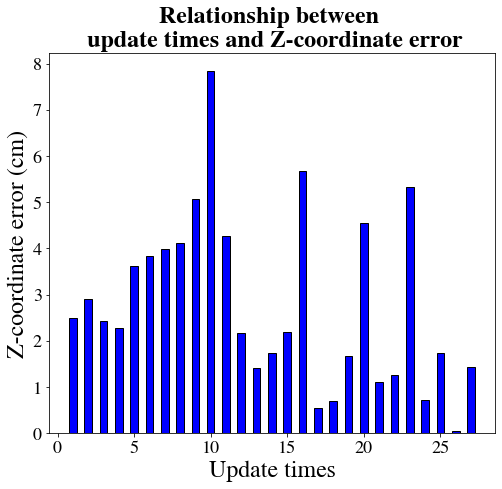

In [43]:
arr_for_vis = np.array([0,0,0,0])
arr_for_pred_3rd = np.array([0,0,0,0])
arr_for_pred_end = np.array([0,0,0,0])

obj.reset_args()

for i in range(0,1):
    trajectory = dataset[i,:]
    trajectory = trajectory.reshape(1,trajectory.shape[0])
    #trajectory = sequence.pad_sequences(trajectory, maxlen=trajectory.shape[1]+27, padding='post', dtype='float32')
    trajectory = trajectory.reshape(trajectory.shape[1],)
    for j in range(0, trajectory.shape[0], 3):
        obj.assigne(trajectory[j:j+3].reshape(1,3))
    #obj.traj_done = True
    
    obj.traj_done = True
    obj.assigne(np.array([0,0,0]))
    vis_arr = obj.return_vis_point()
    pred_arr = obj.return_pred_res()
    #print("")
    #print("vis from obj = \n", vis_arr)
    #print("pred from obj = \n", pred_arr)
    #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
    '''
    if pred_arr.shape[0] > 20:
        arr_for_vis = np.vstack((arr_for_vis, vis_arr))
        arr_for_pred_3rd = np.vstack((arr_for_pred_3rd, pred_arr[2,:]))
        arr_for_pred_end = np.vstack((arr_for_pred_end, pred_arr[(pred_arr.shape[0]-10),:]))
    #obj.reset_arr_pred()
    '''

In [14]:
pred_from_obj = obj.print_arr_pred()
print(pred_from_obj)

[[  0.7371  74.0745 -45.      26.3338]
 [  0.7339 111.5844 -45.      27.1146]
 [  0.7339 111.5844 -45.      27.1146]
 [  0.739  110.8727 -45.      26.6946]
 [  0.739  110.8727 -45.      26.6946]
 [  0.7433 109.4792 -45.      27.1849]
 [  0.7433 109.4792 -45.      27.1849]
 [  0.7414 107.7843 -45.      27.3275]
 [  0.7414 107.7843 -45.      27.3275]
 [  0.7462 106.8041 -45.      25.9786]
 [  0.7462 106.8041 -45.      25.9786]
 [  0.7427 105.5734 -45.      25.7696]
 [  0.7427 105.5734 -45.      25.7696]
 [  0.7353 102.3912 -45.      25.6149]
 [  0.7353 102.3912 -45.      25.6149]
 [  0.7616 101.7632 -45.      25.4872]
 [  0.7616 101.7632 -45.      25.4872]
 [  0.7665 101.2635 -45.      24.5453]
 [  0.7665 101.2635 -45.      24.5453]
 [  0.7832  90.476  -45.      21.7693]
 [  0.7832  90.476  -45.      21.7693]
 [  0.7745  97.7204 -45.      25.3346]
 [  0.7745  97.7204 -45.      25.3346]
 [  0.7731  95.4135 -45.      27.4262]
 [  0.7731  95.4135 -45.      27.4262]
 [  0.779   93.3759 -45. 

In [16]:
pred_from_obj.shape

(55, 4)

In [24]:
def modify_plot(tmp):
    arr = np.array([0,0,0,0])
    for i in range (tmp.shape[0]):
        if i % 2 != 0:
            arr = np.vstack((arr, tmp[i,:]))
    return arr[1:,:]

(27, 4)


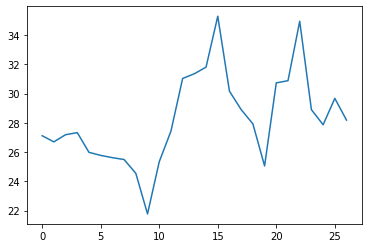

In [34]:
aaa = modify_plot(pred_from_obj)
print(aaa.shape)
plt.plot(cp.asnumpy(aaa[:,3]))

In [40]:
arr_pred_possible, vis_hitting_point, update_times, t, x, z, Euclidean_vis, Euclidean_pred = obj.return_plot_arg()

In [43]:
z

array([33.45512349, 34.26055043, 33.43782206, 32.22320248, 32.51906767,
       31.9545584 , 33.15452371, 30.23234106, 31.93413959, 35.29804712,
       33.84807563, 32.45081747, 32.55905297, 31.97958692, 38.59134948,
       42.81067791, 42.75950028, 34.67436803, 36.91727023, 36.88537319,
       35.57977325, 35.57977325, 35.57977325, 32.44390782, 30.39479014,
       33.49176291, 34.37828476, 35.49528267])

Text(0.5, 1.0, 'Relationship between \n update times and hitting timing')

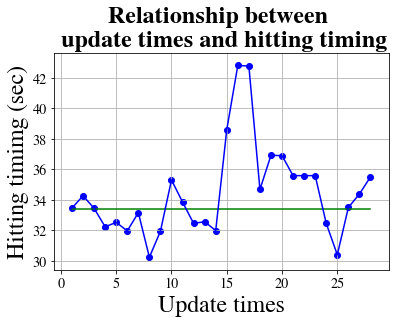

In [36]:
plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((arr_pred_possible.shape[0],))*vis_hitting_point[3]), color='green') #vis
plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue') #pred
plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
plt.grid(True)
plt.xticks(fontsize=14, fontname='FreeSerif')
plt.yticks(fontsize=14, fontname='FreeSerif')
plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
plt.ylabel('Hitting timimg (sec)', fontsize=24, fontname='FreeSerif')
plt.title('Relationship between \n update times and hitting timing', fontsize=24, fontweight='bold', fontname='FreeSerif')